# Exploração de carcterísticas

In [23]:
import os
from os.path import join, dirname
from dotenv import load_dotenv

dotenv_path = join(dirname('__file__'), '.env')

load_dotenv(dotenv_path)

ROOT_PATH = os.environ.get("ROOT_PATH")


In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.io import loadmat


In [29]:
df = pd.read_parquet(f"{ROOT_PATH}/features/features.parquet")


In [31]:
df = df.astype({
    'var': float,
    'skew': float,
    'kur': float,
    'label': str
})


In [37]:
df.file.unique()

array(['PN00-2', 'PN00-3', 'PN00-4', 'PN05-2', 'PN05-3', 'PN06-3',
       'PN09-1', 'PN09-2', 'PN09-3', 'PN10-2', 'PN13-1', 'PN13-2',
       'PN13-3'], dtype=object)

In [34]:
df[df['file']=='PN13-3']

,var,skew,kur,label,file
0,-106345.345017,-106344.179629,-106340.757870,ictal,PN13-3
1,-106345.340449,-106344.189882,-106340.852668,ictal,PN13-3
2,-106345.337254,-106344.199821,-106340.855523,ictal,PN13-3
3,-106345.336864,-106344.208118,-106340.898636,ictal,PN13-3
4,-106345.343481,-106344.225997,-106340.892453,ictal,PN13-3
...,...,...,...,...,...
80,-41400.662211,-41399.524561,-41396.334438,rep,PN13-3
81,-41400.660453,-41399.518774,-41396.201892,rep,PN13-3
82,-41400.661509,-41399.529917,-41396.313938,rep,PN13-3
83,-41400.659834,-41399.545186,-41396.292056,rep,PN13-3


<AxesSubplot:xlabel='label', ylabel='var'>

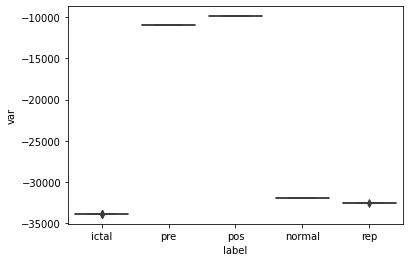

In [38]:
d = df[df['file']=='PN13-2']

sns.boxplot(data=d, x='label',y='var')

<AxesSubplot:xlabel='label', ylabel='var'>

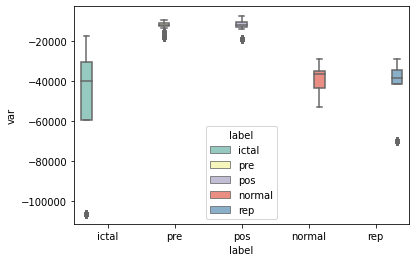

In [22]:
sns.boxplot(x="label", y="var", hue="label", data=df, palette="Set3")

<AxesSubplot:xlabel='label', ylabel='kur'>

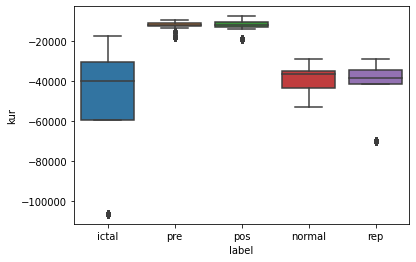

In [18]:
sns.boxplot(data=df, x='label',y='kur')

<AxesSubplot:xlabel='var', ylabel='kur'>

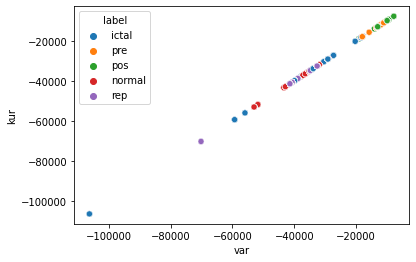

In [15]:
sns.scatterplot(data=df,x='var',y='kur',hue='label')

In [54]:
file = 'PN00-2.mat'

path = f"{ROOT_PATH}{PROCESSED_DATA}ecg_features/"


In [56]:
loadmat(f"{path}com_crise/{file}")


{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Wed Apr  6 02:41:21 2022',
 '__version__': '1.0',
 '__globals__': [],
 'None': MatlabOpaque([(b'tt', b'MCOS', b'table', array([[3707764736],
                      [         2],
                      [         1],
                      [         1],
                      [         1],
                      [         1]], dtype=uint32))           ],
              dtype=[('s0', 'O'), ('s1', 'O'), ('s2', 'O'), ('arr', 'O')]),
 '__function_workspace__': array([[ 0,  1, 73, ...,  0,  0,  0]], dtype=uint8)}

In [41]:
sem_crise = pd.read_parquet(f"{path}sem_crise/{file}")
com_crise = pd.read_parquet(f"{path}com_crise/{file}")

# Inserindo rótulos
# Sem crise -> 1
# Com crise -> 0
sem_crise['label'] = np.repeat('sem_crise', len(sem_crise))
com_crise['label'] = np.repeat('com_crise', len(com_crise))

df = pd.concat([sem_crise, com_crise])


In [42]:
# Tratamento de valores nulos
for col in df.columns[:-1]:
    df[col] = df[col].fillna(df[col].mean())


## Seleção de Características

- Selecionando as 2 features como maior relevância

In [6]:
from sklearn.feature_selection import SelectKBest, f_classif

x = df.iloc[:, :-1]
y = df.iloc[:, -1]

sel = SelectKBest(f_classif, k=2)
new = sel.fit_transform(x, y)
cols_features = sel.get_feature_names_out()

cols_features


array(['kur_log_entropy', 'energy_log_entropy'], dtype=object)

In [43]:
data = df


In [7]:
data = pd.DataFrame(data=new, columns=cols_features)
data['label'] = y.to_list()


## Boxplot de grupos

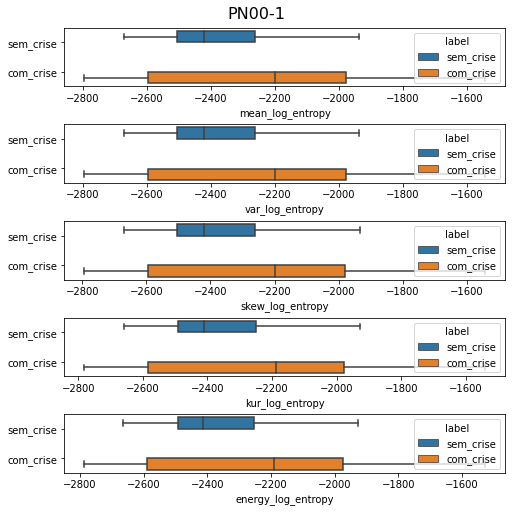

In [44]:
fig, axs = plt.subplots(5, 1, figsize=(7, 7), constrained_layout=True)

for col in range(len(data.columns[:-1])):
    sns.boxplot(y="label", x=data.columns[col], hue="label",
                data=data, ax=axs[col], showfliers=False)
    axs[col].set_ylabel('')

fig.suptitle(file.replace('.parquet', ''), fontsize=16)

fig.savefig(
    f"{ROOT_PATH}reports/figures/ecg_features/{file.replace('parquet','')}jpg")


In [274]:
data.to_parquet(f"{ROOT_PATH}{PROCESSED_DATA}ecg_features_select/{file}")
